# Search Terms Classification
<< Outline of notes >>
#### 1. MVP
#### 2. Suggested trimmed down version of MVP
#### 3. Lessons from MVP
#### 4. Weaknesses in the model
#### 5. Other techniques and models we tried

 # 1. MVP

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('trainSet.csv', names=['text', 'label'], header=None)
df.head()

,text,label
0,yew hedge,1221
1,fire detection shop,19
2,cheap couch roll,398
3,extra watermelon gum,1108
4,used generators for sale uk,213


In [3]:
df.shape

(606823, 2)

In [4]:
df['label'].nunique()

1419

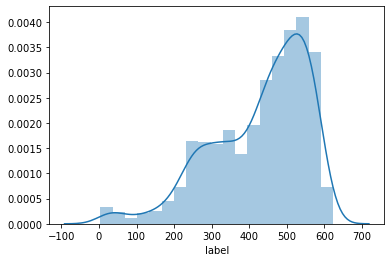

In [5]:
sns.distplot(df['label'].value_counts())

In [6]:
df['label'].value_counts().describe()

count    1419.000000
mean      427.641297
std       128.526016
min         4.000000
25%       338.500000
50%       461.000000
75%       530.000000
max       623.000000
Name: label, dtype: float64

In [7]:
df['label'].value_counts().median()

461.0

* Frequency of labels has a mean of 427, median 461 (more relevant to this distribution since it is left skewed). 
* variance of the frequency of labels is high. we could later on try to merge some low frequency labels and see if that has any impact on accuracy and other evaluation metircs of the algorithm that we select
* it is advisable not to delete the rows containing low frequency labels because that will have a bearing on accuracy of scoring

In [8]:
np.random.seed(500)

* Pre-Processing

In [9]:
df.isnull().sum()

text     0
label    0
dtype: int64

* Remove blank rows if any. There aren't any, but just in case the model in used in the future on a different training dataset

In [10]:
df['text'].dropna(inplace=True)

* Change all the text to lower case

In [11]:
df['text'] = [entry.lower() for entry in df['text']]

* Remove punctuation

In [12]:
import string


PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df['text'] = df['text'].apply(lambda text: remove_punctuation(text))

* Remove stopwords

In [13]:
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['text'] = df['text'].apply(lambda text: remove_stopwords(text))

* Remove frequent words

In [14]:
from collections import Counter
cnt = Counter()

FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df['text'] = df['text'].apply(lambda text: remove_freqwords(text))

* Remove rare words

In [15]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df['text'] = df['text'].apply(lambda text: remove_rarewords(text))

* Stemming

In [16]:
from nltk.stem.porter import PorterStemmer


stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df['text'] = df['text'].apply(lambda text: stem_words(text))

* Word-Net Lemmatizer
<br>
(This takes for ever, even when less training data is selected. As such it is the first item taken out from the MVP. But included here for the purposes of discussion)

In [17]:
# from nltk.stem import WordNetLemmatizer

# lemmatizer = WordNetLemmatizer()
# def lemmatize_words(text):
#     return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# df['text'] = df['text'].apply(lambda text: lemmatize_words(text))

# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer
# import nltk

# lemmatizer = WordNetLemmatizer()
# wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
# def lemmatize_words(text):
#     pos_tagged_text = nltk.pos_tag(text.split())
#     return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

# df['text'] = df['text'].apply(lambda text: lemmatize_words(text))

* looking at some examples to see how the impact of skipping lemmatization in our model

In [166]:
df[df['label']==213]

,text,label
4,used generators sale uk,213
2488,tesla generator,213
4357,markon generator,213
6508,30 kva generator,213
7273,second hand generators sale uk,213
...,...,...
602370,top magnetic generator,213
602845,simply generators,213
603264,pramac p11000,213
605944,medusa generator,213


* Looking at the above example of label 213, if we do NOT lemmatize the text column then 'generator' and 'generators' will have two separator columns upon vectorization. that increases the dimentionality of the data unnecessarily without increasing accuracy of prediction (because there is little semantic difference between a singular and a plural). in order to limit dimentionality and make the final model run faster it is better to do lemmatization during training of the data. so there is a trade off: lemmatizing increases training time but decreases scoring time, and more importantly the scoring will be more accurate. so if we are running batch process then we could opt for lemmatization. if we are dealing with real-time classification of search terms then lemmatization is not a good idea in this case. 
* in practice i tried lemmatization but it did not improve accuracy at test stage!!!

* Tf-Idf Word Embedding

In [18]:
# if we dont specify max_features the vectorizer builds a vocabulary that only consider the top max_features ordered by term frequency across the corpus
tfidf = TfidfVectorizer()

* we choose tf-idf vectorization since we have labelled data
* accuracy score of the model depends on the max_features in this vectorizer. accuracy was found to vary from 50% to 56% (for naive bayes multinomial calssifier) as we vary the number of max_features from around 5000 to 150k.  
* tf-idf values depend not only on the count of a specific word in the search term but also on the count of that specific word in the overall corpus. so it tells the classifier somewhat similar info as the countvectorizer does in our context because a typical search term will not have multiple occurances of a particular word. in theory therefore countvectorizer should be able to perform just as well as tf-idf for our classification.
* compared to 55% accuracy in case of tf-idf (mx_features as default), countvectorizer gives 53% accuracy.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.33, random_state=42)

In [21]:
X_train_mat = tfidf.fit_transform(X_train)
X_test_mat = tfidf.transform(X_test)

* Models

In [22]:
# Try SGDClassifier
# Takes 15 minutes on my machine to train and test. Returns accuracy of 54%

from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train_mat,y_train)
# predict the labels on validation dataset
predictions_sgd = sgd.predict(X_test_mat)
# Use accuracy_score function to get the accuracy
print("SGD Accuracy Score -> ",accuracy_score(predictions_sgd, y_test)*100)

SGD Accuracy Score ->  54.02293110680543


In [23]:
# Try Naive Bayes Multinomial classifier
# Takes 15 seconds on my machine to train and test. Returns accuracy of 55%

Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_mat,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test_mat)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  55.47659948464935


In [24]:
# Try OneVsRestClassifier
# Takes 18 minutes on my machine to train and test. Returns accuracy of 62%

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

y_pred_ovrc = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X_train_mat,y_train).predict(X_test_mat)

print("OVR Accuracy Score -> ",accuracy_score(y_pred_ovrc, y_test)*100) 

OVR Accuracy Score ->  61.61236841579609


In [ ]:
# Random Forest and Logistic Regression are not appropriate models here. They were tested nevertheless. 
# Apart from being inappropriate here they take too long to run and the accuracy returned is low

* Naive Bayes Multinomial performs well in multi class classification. When assumption of independence holds (and our search terms can be presumed to be independent of each other ... from the perspective of where they have been sourced from), a Naive Bayes classifier performs better compare to other multi-class classification models and you need less training data.
* In terms of model choice so far Naive Bayes Multinomial is a winner. It takes 15 seconds to train and test the entire dataset. However the pre-processing take a couple of minutes. We did not try lemmatizing because that takes for ever. We skipped lemmatizing therefore. I am below testing same naive bayes model on the data without some of the other pre-processing items such as stemming, removing punctuation/stopwords/rare words/frequent words etc
* As was tested below, it takes 18 seconds to train and test, far less time than when we do the above mentioned pre-processing items. Furthermore without pre-processing scenario (with only the vectorization) returns similar accuracy level of 55% as was the case in pre-processing scenario
* Key take away from this comparison is that a lot of preprocessing items are redundant and not yielding any higher accuracy. Therefore we should straightaway go for vectorization of the search terms 

# 2. Suggested trimmed down version of MVP

In [46]:
# Takes 18 seconds to pre-process data, train on data and test
# Returns similar accuracy level of 55% despite skipping a lot of the conventional pre-processing items

df= pd.read_csv('trainSet.csv', header=None, names=['text', 'label'])
np.random.seed(500)
df['text'].dropna(inplace=True)
df['text'] = [entry.lower() for entry in df['text']]
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.33, random_state=42)
tfidf = TfidfVectorizer() 
X_train_mat = tfidf.fit_transform(X_train)
X_test_mat = tfidf.transform(X_test)
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_mat,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test_mat)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  55.39620078700837


* classification report

In [47]:
# top 10 labels by f1-score
report_df = pd.DataFrame(classification_report(predictions_NB, y_test, output_dict=True)).transpose()
report_df.sort_values(by='f1-score', ascending=False).head(10)

,precision,recall,f1-score,support
453,0.873418,0.938776,0.904918,147.0
533,0.876147,0.841410,0.858427,227.0
617,0.847826,0.862832,0.855263,226.0
1130,0.881517,0.830357,0.855172,224.0
964,0.770642,0.954545,0.852792,88.0
320,0.912281,0.800000,0.852459,195.0
1024,0.834146,0.859296,0.846535,199.0
264,0.793651,0.900901,0.843882,111.0
501,0.878453,0.811224,0.843501,196.0
669,0.752137,0.946237,0.838095,93.0


* we could extract three differnt streams of info here: recall specific, precision specific, a weighted-average specific (f1-score). that depends on the preferences of the clients. those who want to grab as much market/visibility during search as possible we can go for high recall approach. we can find out from this table which labels we are able to get a high recall on. similarly those clients who prefer a better conversion rate of a higher contextual similarity with the search term we can go for the high precision approach and share the high precision labels with them. 

# 3. Lessons from MVP
* A lot of the conventional nlp related pre-processing does not bring about any tangible improvement in the prediction accuracy of the model in this case
* Stemming, removal of punctuation/stopwords/rare words/frequent words does not help improve accuracy of the model. In fact removing rare and frequent words might do harm to our model because those rare/frequent words might be critical to the context of the search term. Other stuff like removing numeric data will not help because they are also relevant search terms and are common while refering to model numbers of products etc etc
* Lemmatization has not helped improve accuracy in practice. However in theory it is a much better pre-processing option than most other options. It can reduce dimentionality in our feature set. But it takes a lot of memory. Lemmatization is not a good option here unless we are going to do batch process mainly
* The idea of merging labels could be tried. But as can be demonstrated below, it worsens the predicting power of the algorithm
* Pre-processing analysis tells us that this problem is more a multiclass classification problem than an nlp problem. It must therefore be approached as such.
* It seems that word vectorization is the main data processing that is relevent here. 
* In terms of model, Naive Bayes Multinomial is giving a near real-time performance. Given sufficient cpu power this model can be deployed in real time in large search traffic environments

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

##### Lets us test merging low frequency labels and see if that improves accuracy
* We will try one more item of pre-processing: merging low frequency labels
* lets see if that improves accuracy

In [28]:
df.label.value_counts()

54      623
1026    609
39      609
291     608
533     607
       ... 
173      16
1309     14
554      14
826      10
587       4
Name: label, Length: 1419, dtype: int64

In [30]:
df.label.value_counts().describe()

count    1419.000000
mean      427.641297
std       128.526016
min         4.000000
25%       338.500000
50%       461.000000
75%       530.000000
max       623.000000
Name: label, dtype: float64

* so lets keep those labels which have frequency of 300 or above. that would be about 25% of the labels in the dataset. so those with less than 300 frequency we put under one label. we keep all the high frequency labels because those terms frequently searched and hence might threfore be important (commercially as well as statistically)

In [29]:
our_labels=[]
for x in df['label'].unique():
    if (df['label'] == x).sum() < 300:
        our_labels.append(x)
len(our_labels)

263

* there are 263 such labels whose frequency in the dataset falls below 300

In [31]:
# relabel them as '5000'

df.loc[df['label'].isin(our_labels), 'label'] = 5000

In [33]:
df.sample(20)

,text,label
497886,garden roller for sale,1410
575287,porady prawne darmowe,5000
568572,potting sheds uk,396
587862,slimming world vegetarian cookbook,679
273091,small jewelry box,1226
267186,apple audiobooks,460
582937,boot sale app,414
107686,gardeners cardiff,1316
10036,time share prices,1360
396857,british army food,466


In [35]:
# of some 600k search terms about 56k have now been merged under one label '5000'

(df['label']==5000).sum()

56762

* let us now see if this makes any difference to our model accuracy

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.33, random_state=42)
tfidf = TfidfVectorizer() 
X_train_mat = tfidf.fit_transform(X_train)
X_test_mat = tfidf.transform(X_test)

# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_mat,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test_mat)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  10.156702554780976


* accuracy dropped from 55% to 10% when we merged the labels that have frequency less than 300. so merging those low frequency labels was not a good idea. 
* this implies that there is enough information in the less frequent labels that helps the classifier distinguish across the spectrum of labels better. so the less frequent labels serve an important purpose in the dataset. this also points to the need to train as much data as possible during training. capturing a wide variety of classes/labels seems critical to accuracy. 
* you could delete the less frequent labels from the dataset. but the problem is the accuracy of the predictions on the hold out set will be very low in that case. 

In [37]:
# lets see what is happenning to recall/precision upon merging the low frequent labels

report2 = classification_report(predictions_NB, y_test, output_dict=True)
report_df2 = pd.DataFrame(report2).transpose()

print('mean recall ',report_df2['recall'].mean())
print('mean precision ',report_df2['precision'].mean())
print('mean f1-score ',report_df2['f1-score'].mean())

mean recall  0.19801146433045663
mean precision  0.009050422814751062
mean f1-score  0.013742437714871035


* it seems that with merging of low frequency labels under one label, both the average recall and average precision has gone down significantly. this is especially so in case of precision which has dropped dramatically. 
* there are cases with a very high recall and a very low precision. in such cases our our predictor/algorithm is predicting too many such labels, like throwing tonnes of mud and hoping some of it might stick. in that effort the recall improves but precision goes down
* notice that recall is 10% on label5000 and precision is almost 100%. despite the fact that algorithm had about 56k examples of label5000 to train on, it has not been able to map search terms (that were under label5000) as label5000. meaning the learning of label5000 is not good despite a huge number of examples to learn from. this means that the search terms under label5000 were very very diverse and could not be generalised (semantically) under one label. this therefore is another reason why we must not merge low frequency labels

In [45]:
report_df2.reset_index()
#report_df2[report_df2['index']==5000]   #.sort_values(by='precision', ascending=False)   #by=['recall', 'precision']

,index,precision,recall,f1-score,support
0,0,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.000000
4,4,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...
1155,1418,0.000000,0.000000,0.000000,0.000000
1156,5000,0.998196,0.094776,0.173115,198510.000000
1157,accuracy,0.101567,0.101567,0.101567,0.101567
1158,macro avg,0.008123,0.198178,0.013529,200252.000000


# 4. Weaknesses in the model

* could have explored some further evaulation metrics 
* hiearchy of labels would have helped achieve better accuracy. accuracy achieved is low.
* need a supervised learning word vectorizer that operates on inherent semantic similarity. something like a cross between tf-idf and word2vec
* some more pre-processing could have been done. like removing search terms which have duplicate labels. search term 'domain' has two different labels. 'value car' has multiple labels. these issues could have been fixed with more eda provided more time is granted
* if we intend to run batch process then other alogorithms can also be more suitable. like we demonstrated that ovr classifier gave better accuracy that naive bayes multinomial
* could have tried ensemble of boosted trees as that is also a good fit for multiclass classification problems

# 5. Other techniques and models we tried

### Deep Learning model

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [21]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df.text.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17514 unique tokens.


In [22]:
X = tokenizer.texts_to_sequences(df.text.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (50000, 250)


In [23]:
Y = pd.get_dummies(df.Category).values


In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(45000, 250) (45000, 1413)
(5000, 250) (5000, 1413)


In [25]:
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1413, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
633/633 [==============================] - 399s 631ms/step - loss: 7.1310 - accuracy: 0.0044 - val_loss: 6.7455 - val_accuracy: 0.0229
Epoch 2/5
633/633 [==============================] - 392s 620ms/step - loss: 5.9524 - accuracy: 0.0877 - val_loss: 5.3976 - val_accuracy: 0.1613
Epoch 3/5
633/633 [==============================] - 395s 623ms/step - loss: 4.4923 - accuracy: 0.2492 - val_loss: 4.5306 - val_accuracy: 0.2580
Epoch 4/5
633/633 [==============================] - 408s 645ms/step - loss: 3.4652 - accuracy: 0.3880 - val_loss: 4.1230 - val_accuracy: 0.2976
Epoch 5/5
633/633 [==============================] - 383s 605ms/step - loss: 2.7865 - accuracy: 0.4873 - val_loss: 3.9119 - val_accuracy: 0.3244


In [52]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

5000/5000 [==============================] - 15s 3ms/step
Test set
  Loss: 3.958
  Accuracy: 0.326


In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

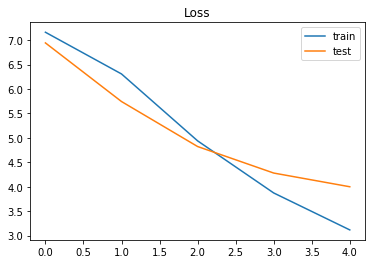

In [54]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

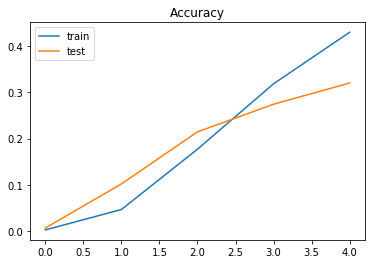

In [55]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

# END